In [1]:
from __future__ import division, absolute_import

import os
import sys
import random

import numpy as np
import datetime

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

#from src.Target import Target

np.random.seed(8)
random.seed(8)

from src.preprocessing import *
from src.model_architecture import *
from src.training_model import *
from src.postprocessing import *
from src.comparing_results import *
#from src.callbacks import *
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Defining parameters

In [2]:
list_paddings = ['post_padding', 'pre_padding', 'mid_padding', 'stretch_padding', 'ext_padding', 
                 'rdm_padding', 'aug_padding']
list_padding_short = ['post_padding', 'pre_padding', 'mid_padding', 'stretch_padding', 'ext_padding', 
                 'rdm_padding']
#hierarchy of folders: annotation/dataset/architecture/n_neurs/task/padding
folder = 'EC_number/archaea/3denses/bio_neurons/'
column = "EC number"

n_folds = 10

# Pre-processing

Max length: (9159, 505)


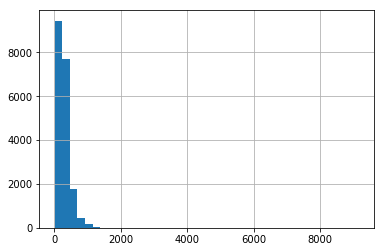

In [3]:
#loading data
file_in= "".join([absPath, 'raw_data/uniprot-reviewed_yes+AND+taxonomy_archaea-EC.tab.gz'])
df = loading_data(file_in, column)
#max len
max_len = looking_max_len(df)
print("Max length:", max_len)
#max_lenn = max_len[1]
max_lenn = 1000
#filtering
df_filt = filtering_over_maxlen(df, max_lenn)
dicti = creating_dict()

In [4]:
#processing sequences
dicti_padding = {}
for i in list_padding_short:
    dicti_padding[i] = processing_sequences(df_filt, i, max_lenn)

0        MIIGYFDGLCEPKNPGGIATFGFVIYLDNRKIEGYGLAEKPFSINS...
1        MIIEGEVVSGLGEGRYFLSLPPYKEIFKKILGFEPYEGTLNLKLDR...
2        MNINEILKKLINKSDLEINEAEELAKAIIRGEVPEILVSAILVALR...
3        MVVPLKRIDKIRWEIPKFDKRMRVPGRVYADEVLLEKMKNDRTLEQ...
4        MERAFIEWYPRGYGVAFKIKKKIYEKLSKYQKIEVYETEGFGRLLA...
5        MMMGVELAFPKVVGKQVYGSLYECDEDVLKDTKRLEQIIKEAADIG...
6        MPRLIKDRVPTPERSVGERVRDFGEVNLGYSWELALREAERCLQCP...
7        MGYNEQERAFIEWYPRGYGVGFKVKRRLFETQTEYQRLEIYETEGF...
8        MVDIVKRRDWEKKEKKKIAIERIDTLFTLAERVARYSPDLAKRYVE...
9        MNVEEMKKIAAKEALKFIEDDMVIGLGTGSTTAYFIKLLGEKLKRG...
10       MKKRVVTAGTFDILHPGHYEILKFAKSLGDELIVIVARDETVKKLK...
11       MNNVEKAIEALKKGEIILVYDSDEREGETDMVVASQFITPEHIRIM...
12       MVMVMEKKPYIISNVGMTLDGKLATINNDSRISCEEDLIRVHKIRA...
13       MAVVKEVLEIAEKIKNMEIRGAGKIARSAAYALQLQAEKSKATNVD...
14       MRLSWVIGGAQGTGIDTAANIFGNAVASAGYYIYGNREYYSNIKGG...
15       MAAFTPQWNDWCPGCGNFGILNAEQQAIVELGVDTKNVVVVSGIGC...
16       MVEKFDTIYDYYVDKGYEPSKKRDIIAVFRVTPAEGYTIEQAAGAV.

0        M000000I000000I000000G000000Y000000F000000D000...
1        M0000000I0000000I0000000E0000000G0000000E00000...
2        M00N00I00N00E00I00L00K00K00L00I00N00K00S00D00L...
3        MVVPLKR0IDKIRWE0IPKFDKR0MRVPGRV0YADEVLL0EKMKND...
4        M000E000R000A000F000I000E000W000Y000P000R000G0...
5        M0000000M0000000M0000000G0000000V0000000E00000...
6        M0P0R0L0I0K0D0R0V0P0T0P0E0R0S0V0G0E0R0V0R0D0F0...
7        M00G00Y00N00E00Q00E00R00A00F00I00E00W000Y00P00...
8        M0000000V0000000D0000000I0000000V0000000K00000...
9        M000N000V000E000E000M000K000K000I000A000A000K0...
10       M000000K000000K000000R000000V000000V000000T000...
11       M000N000N000V000E000K000A000I000E000A000L000K0...
12       M000V000M000V000M000E000K000K000P000Y0000I000I...
13       M00A00V00V00K00E00V00L00E00I00A00E00K00I00K00N...
14       MR0LS0WV0IG0GA0QG0TG0ID0TA0AN0IF0GN0AV0AS0AG0Y...
15       M00A00A00F00T00P00Q00W00N00D00W00C00P00G00C00G...
16       M0V0E0K0F0D0T0I0Y0D0Y0Y0V0D0K0G0Y0E0P0S0K0K0R0.

In [5]:
len(dicti_padding["post_padding"][0])

1000

1.0    10658
0.0     8727
Name: enzyme, dtype: int64
(7,)
Shape of the resulting encoding (19385, 7)
There are  214 samples with more than one label
The unique labels are  ['3', '2', '4', '1', '5', '6', 'nan', '7']


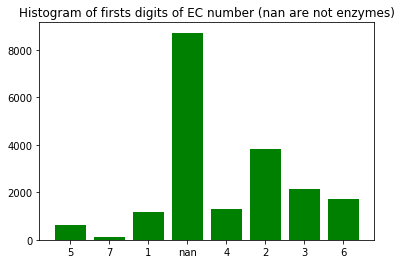

In [6]:
# creating binary enzyme/no enzyme label
df_bin = binarizing_EC(df_filt)

#processing enzyme class label
df_digit1 = first_digit_EC(df_bin)

labels_task1 = bin_to_onehot(df_digit1, 2)

ec_multilabel = encoding_as_multilabel(df_digit1, folder)

data_to_hdf5(folder, 'data.h5', list_padding_short, dicti_padding, labels_task1, ec_multilabel)

counting_multilabel(df_digit1)

In [7]:
#splitting indices
splitting_sets = splitting_sets(0.7, 0.5, dicti_padding['post_padding'], ec_multilabel, folder, kfold_bool=True, n_splits=n_folds)

#creating augmented data
creating_augmented_data(dicti_padding, labels_task1, splitting_sets, folder, 'aug_data.h5', 
                            labels_task2 = ec_multilabel, kfold_bool = True)

# keeping indices enzymes total data
keeping_indices_enzymes(labels_task1, splitting_sets, folder, 'idcs_data_enz.h5', True)

#keeping indices enzymes aug data
file_data = os.path.join(absPath, 'data/', folder, 'aug_data.h5')
h5f = h5py.File(file_data, 'r')
task1_aug = h5f['labels_task1'][:len(h5f['labels_task1'])]


# Loading splitting indices
file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_aug_split.pickle')

with open(file_idcs, "rb") as input_file:
    k_aug_indices = pickle.load(input_file)

keeping_indices_enzymes(labels_task1, splitting_sets, folder, 'idcs_aug_enz.h5', True)

# Defining Deep Learning model  - Task 1

In [8]:
n_class = 2 #number of classes to output
drop_per = 0.2 #Input dropout 
n_neur = [314,77,8]
drop_hid = 0.5
dict_size = len(dicti)

batch_size = 54
epochss = 200

model = building_3dense_model_task1(max_lenn, dict_size, n_neur, n_class, drop_per, drop_hid, 'softmax', folder)

generators_dict = {} 
for model_type in list_paddings:
    generators_dict[model_type] = trainval_generators(splitting_sets, model_type, folder, batch_size, 'labels_task1', True)

W0711 21:03:15.824917 139960592238336 deprecation_wrapper.py:119] From /home/angela/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 21:03:15.836894 139960592238336 deprecation_wrapper.py:119] From /home/angela/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 21:03:15.838696 139960592238336 deprecation_wrapper.py:119] From /home/angela/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0711 21:03:15.844447 139960592238336 deprecation.py:506] From /home/angela/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 26)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 26)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 314)               8164314   
_________________________________________________________________
dropout_2 (Dropout)          (None, 314)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 77)                24255     
_________________________________________________________________
dropout_3 (Dropout)          (None, 77)                0         
__________

In [ ]:
task = "task1/"
for model_type in list_paddings:
    generators = generators_dict[model_type]
    for idx,i in enumerate(generators):
        i_train, i_val, i_test = splitting_sets[idx]
        len_train, len_val, len_test = len(i_train), len(i_val), len(i_test)
        train_generator, val_generator = i
        folder_cp = ''.join(string for string in [folder, task, model_type, '/', str(idx)]) 
        #print(folder_cp)
        if not os.path.exists(os.path.join(absPath, 'data/checkpoint/', folder_cp)):
            os.makedirs(''.join(string for string in [absPath, 'data/checkpoint/', folder_cp]))

        callbacks_list = calling_callbacks(folder_cp, folder, model_type, None, None, None, 
                                   None, False, False, False, False)
        folder_task1 =  ''.join(string for string in [folder, task])
        model = building_3dense_model_task1(max_lenn, dict_size, n_neur, n_class, drop_per, drop_hid, 'softmax', 
                                            folder)
        #writing log file 
        log_file = ''.join(string for string in [absPath, 'data/checkpoint/', folder, task, 'log_file.txt' ]) 
        f = open(log_file, 'a+')
        print('Model type: %s \n' % model_type, file=f)
        print('Fold: %i \n' % idx, file=f)
 
        start = time.time()
        formatted_time = datetime.datetime.now()
        print('Starting time: %s \n' % formatted_time, file=f)
        history = model.fit_generator(generator=train_generator, 
                              validation_data=val_generator,
                             steps_per_epoch= int(len_train/batch_size),
                              validation_steps=int(len_val/batch_size),
                             epochs=epochss,
                             callbacks=callbacks_list,
                             verbose=1)
        end = time.time()
        formatted_endtime = datetime.datetime.now()
        print('Finishing time: %s \n' % formatted_endtime, file=f)
        count_time(start, end, folder, model_type)
        saving_results(history, model_type, folder, idx, True)
        f.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1000, 26)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 1000, 26)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 26000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 314)               8164314   
_________________________________________________________________
dropout_22 (Dropout)         (None, 314)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 77)                24255     
_________________________________________________________________
dropout_23 (Dropout)         (None, 77)                0         
__________

In [ ]:
next(generators[1][0])[0].shape